In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import sys
import pickle
from datetime import datetime, timedelta

sys.path.append('/home/a1jadhav/pfm_root/PFM/sdpm_py_util')

import grid_functions as grdfuns
import plotting_functions as pltfuns
import ocn_functions as ocnfuns

/home/a1jadhav/pfm_root/PFM/sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:
file_path = '/home/ffeddersen/PFM/driver/test_of_ncks.nc'
his_filepath = '/scratch/matt/sdtjre_L1/I06J18/ocean_his_LV1_20192020.nc'
fngr = '/home/mspydell/models/SDPM_root/SDPM/grids/GRID_SDTJRE_LV1.nc'
RMG = grdfuns.roms_grid_to_dict(fngr)

fnout='/scratch/PFM_Simulations/LV1_Forecast/Forc/ocn_dict_file_2024-07-29T12:00.pkl'
with open(fnout,'rb') as fp:
            OCN = pickle.load(fp)
            print('OCN dict loaded with pickle')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/PFM_Simulations/LV1_Forecast/Forc/ocn_dict_file_2024-07-29T12:00.pkl'

In [3]:
print('starting: ocnfuns.hycom_to_roms_latlon(OCN,RMG)')
OCN_R  = ocnfuns.hycom_to_roms_latlon_old(OCN,RMG)
print('driver_run_forecast_LV1: done with hycom_to_roms_latlon')

starting: ocnfuns.hycom_to_roms_latlon(OCN,RMG)
before interp to roms grid, using:
637460
kilobytes
doing:
zeta
doing:
temp
doing:
salt
doing:
u
doing:
v
before rotating urm, using:
4540372
kilobytes
before rotating vrm, using:
6708256
kilobytes
after v rotation. before ubar
driver_run_forecast_LV1: done with hycom_to_roms_latlon


In [9]:
fnout='/home/a1jadhav/test/ocn_R_hycom_dict_file.pkl'
with open(fnout,'wb') as fp:
    pickle.dump(OCN_R,fp)
    print('OCN dict saved with pickle')

OCN dict saved with pickle


In [36]:
def plot_ocn_fields_from_dict(OCN, RMG, fields_to_plot=None, show=False):
    """
    Plot specified fields from a dictionary and save them as PNG files.
    
    Parameters:
    OCN (dict): Dictionary containing the data fields.
    fields_to_plot (list or str): The fields to plot. If None, plot all fields.
    """
    # Extract the common variables
    # timestamp = pltfuns.extract_timestamp_1999(OCN)
    lon = OCN['lon'][:]
    lat = OCN['lat'][:]
    ocean_time = OCN['ocean_time']
    start_time = datetime(1999, 1, 1) + timedelta(days=float(ocean_time[0]))

    if fields_to_plot is None:
        fields_to_plot = ['velocity', 'surf_el', 'water_temp', 'salinity']
    else:
        fields_to_plot = [fields_to_plot] if isinstance(fields_to_plot, str) else fields_to_plot

    for field in fields_to_plot:
        fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': ccrs.PlateCarree()})
        cmap = plt.get_cmap('turbo')
        plt.set_cmap(cmap)

        if field == 'velocity':
            u = OCN['u'][0, 0, :, :]  # surface layer
            v = OCN['v'][0, 0, :, :]  # surface layer
            magnitude = np.sqrt(u**2 + v**2)
            plevs = np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 50)
            cset = ax.contourf(lon, lat, magnitude, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            ax.quiver(lon[::5], lat[::5], u[::5, ::5], v[::5, ::5], transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Velocity Magnitude [m/s]')
            cbar.set_ticks(np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 5))
            ax.set_title('Surface Velocity [m/s]')
        
        elif field == 'surf_el':
            surf_el = OCN['zeta'][0, :, :]
            plevs = np.linspace(np.nanmin(surf_el), np.nanmax(surf_el), 50)
            cset = ax.contourf(lon, lat, surf_el, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Elevation [m]')
            cbar.set_ticks(np.linspace(np.nanmin(surf_el), np.nanmax(surf_el), 5))
            ax.set_title('Surface Elevation [m]')
        
        elif field == 'water_temp':
            water_temp = OCN['temp'][0, 0, :, :]
            plevs = np.linspace(np.nanmin(water_temp), np.nanmax(water_temp), 50)
            cset = ax.contourf(lon, lat, water_temp, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Temperature [°C]')
            cbar.set_ticks(np.linspace(np.nanmin(water_temp), np.nanmax(water_temp), 5))
            ax.set_title('Surface Temperature [°C]')
        
        elif field == 'salinity':
            salinity = OCN['salt'][0, 0, :, :]
            plevs = np.linspace(np.nanmin(salinity), np.nanmax(salinity), 50)
            cset = ax.contourf(lon, lat, salinity, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_ticks(np.linspace(np.nanmin(salinity), np.nanmax(salinity), 5))
            cbar.set_label('Salinity [psu]')
            ax.set_title('Surface Salinity [psu]')
        
        # Add coastlines and gridlines and ROMS box
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
        ax.grid(True)
        pltfuns.plot_roms_box(ax, RMG)
        ax.set_aspect('auto')
        ax.set_xticks(np.round(np.linspace(np.min(lon), np.max(lon), num=5), 2))
        ax.set_yticks(np.round(np.linspace(np.min(lat), np.max(lat), num=5), 2))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
        
        # Set the title and labels
        annotation = f'Timestamp: {start_time.strftime("%Y-%m-%d %H:%M:%S")} | Model: Hycom | Field: {field}'
        ax.text(0.5, 1.05, annotation, transform=ax.transAxes, ha='center', fontsize=12)
        
        
        # for field in fields_to_plot:
        #     if show is True:
        #         output_dir = PFM['lv1_plot_dir']
        #         filename = f'{output_dir}/{timestamp}_hycom_OCN_{field}.png'
        #         plt.savefig(filename, dpi=300)
        #         plt.show()
        #     else:
        plt.show()
        plt.close()

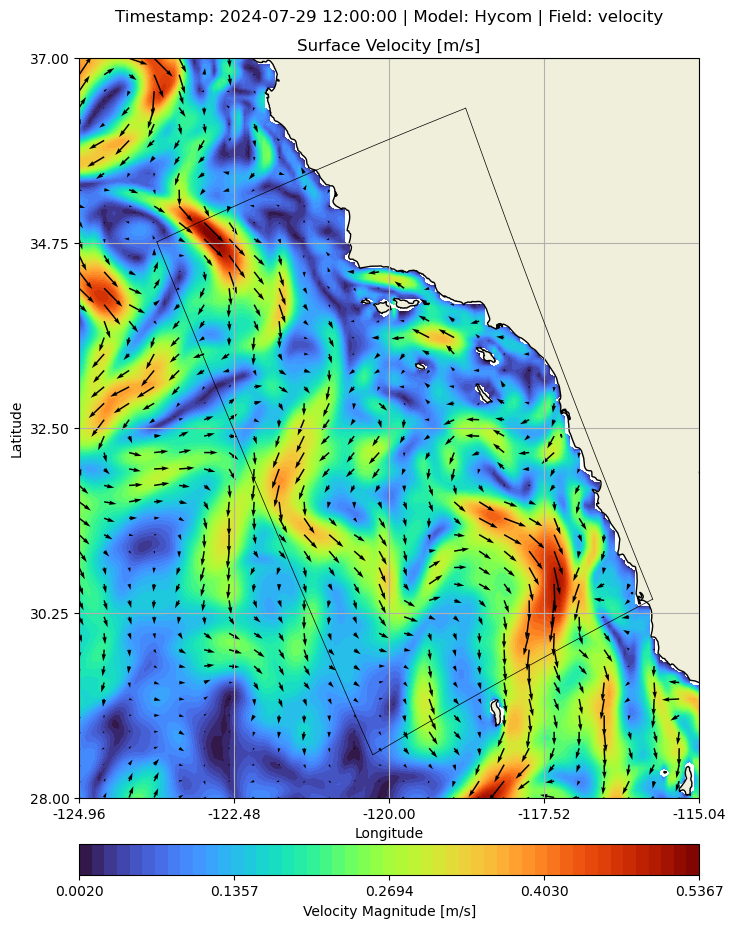

In [39]:
plot_ocn_fields_from_dict(OCN, RMG,'velocity')

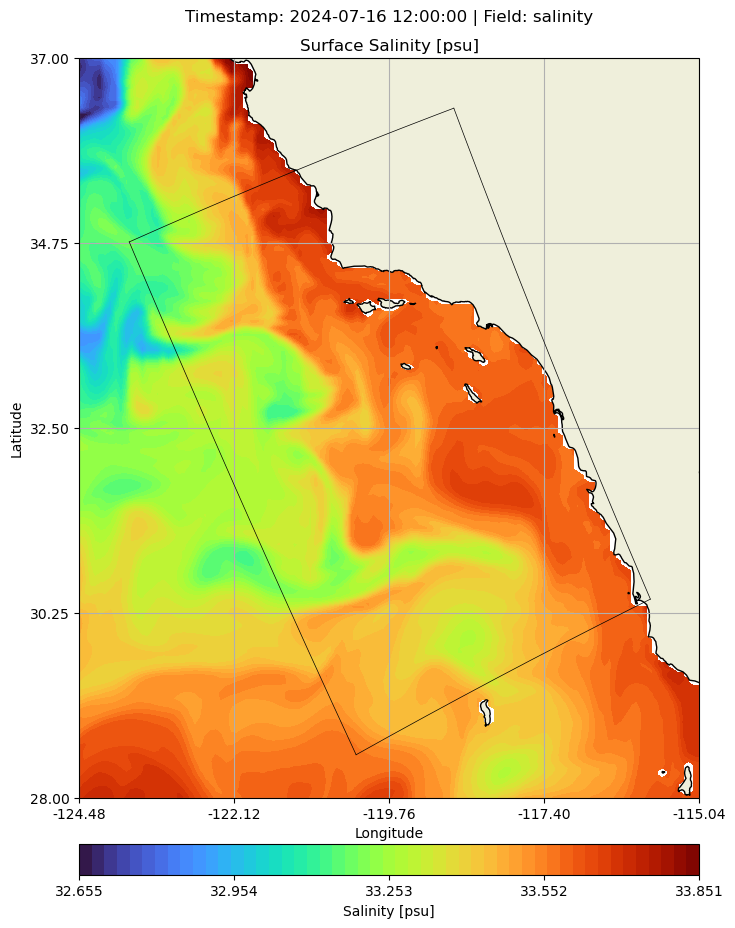

In [3]:
pltfuns.plot_ocn_fields_from_nc(file_path, RMG, 'salinity')

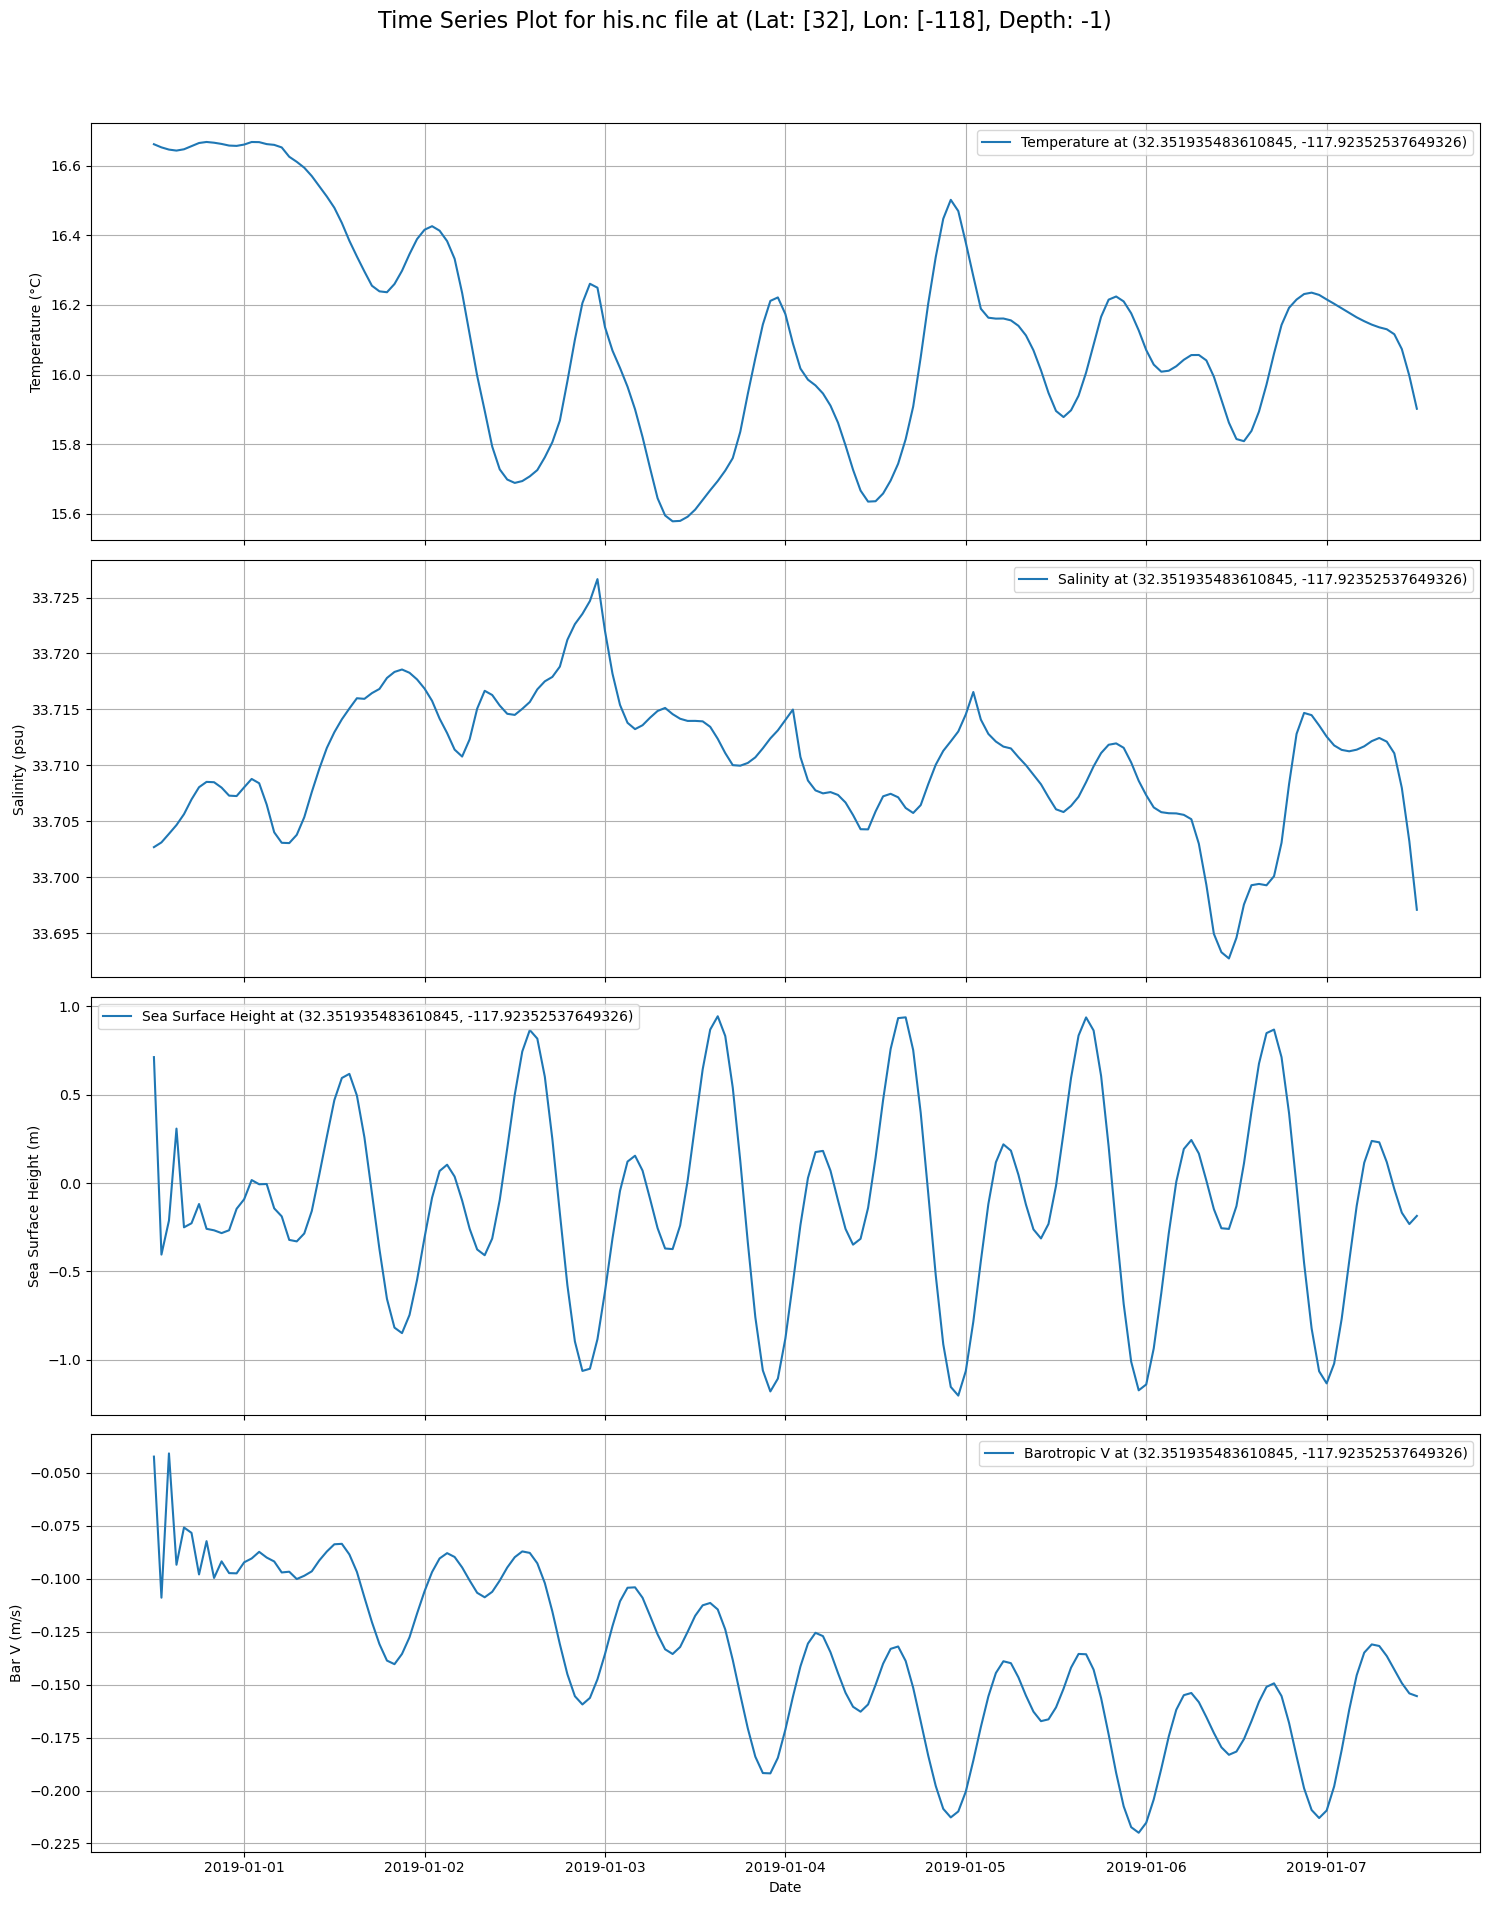

In [6]:
lats = [32]  # Replace with actual latitudes
lons = [-118]  # Replace with actual longitudes
pltfuns.plot_his_time_series(his_filepath, RMG, lats, lons)

In [8]:
def plot_ocn_fields(OCN_R, RMG, fields_to_plot=None, time_index=0, depth_index=0):
    lon = OCN_R['lon_rho']
    lat = OCN_R['lat_rho']
    time = OCN_R['ocean_time'][time_index]
    start_time = nc.num2date(time, units='days since 1999-01-01')

    if fields_to_plot is None:
        fields_to_plot = ['velocity', 'surf_el', 'temp', 'salt']
    else:
        fields_to_plot = [fields_to_plot] if isinstance(fields_to_plot, str) else fields_to_plot

    for field in fields_to_plot:
        fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': ccrs.PlateCarree()})
        cmap = plt.get_cmap('turbo')
        plt.set_cmap(cmap)

        if field == 'velocity':
            u = OCN_R['urm'][time_index, depth_index, :, :]  # surface layer
            v = OCN_R['vrm'][time_index, depth_index, :, :]  # surface layer
            magnitude = np.sqrt(u**2 + v**2)
            plevs = np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 50)
            cset = ax.contourf(lon, lat, magnitude, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            ax.quiver(lon[::5], lat[::5], u[::5, ::5], v[::5, ::5], transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Velocity Magnitude [m/s]')
            cbar.set_ticks(np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 5))
            ax.set_title('Surface Velocity [m/s]')
        
        elif field == 'surf_el':
            zeta = OCN_R['zeta'][time_index, :, :]
            plevs = np.linspace(np.nanmin(zeta), np.nanmax(zeta), 50)
            cset = ax.contourf(lon, lat, zeta, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Elevation [m]')
            cbar.set_ticks(np.linspace(np.nanmin(zeta), np.nanmax(zeta), 5))
            ax.set_title('Surface Elevation [m]')
        
        elif field == 'temp':
            temp = OCN_R['temp'][time_index, depth_index, :, :]
            plevs = np.linspace(np.nanmin(temp), np.nanmax(temp), 50)
            cset = ax.contourf(lon, lat, temp, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Temperature [°C]')
            cbar.set_ticks(np.linspace(np.nanmin(temp), np.nanmax(temp), 5))
            ax.set_title('Surface Temperature [°C]')
        
        elif field == 'salt':
            salt = OCN_R['salt'][time_index, depth_index, :, :]
            plevs = np.linspace(np.nanmin(salt), np.nanmax(salt), 50)
            cset = ax.contourf(lon, lat, salt, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_ticks(np.linspace(np.nanmin(salt), np.nanmax(salt), 5))
            cbar.set_label('Salinity [psu]')
            ax.set_title('Surface Salinity [psu]')
        
        # Add coastlines and gridlines and ROMS box
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
        ax.grid(True)
        pltfuns.plot_roms_box(ax, RMG)
        ax.set_aspect('auto')
        ax.set_xticks(np.round(np.linspace(np.min(lon), np.max(lon), num=5), 2))
        ax.set_yticks(np.round(np.linspace(np.min(lat), np.max(lat), num=5), 2))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
        
        # Set the title and labels
        annotation = f'Timestamp: {start_time.strftime("%Y-%m-%d %H:%M:%S")} | Field: {field}'
        ax.text(0.5, 1.05, annotation, transform=ax.transAxes, ha='center', fontsize=12)
        
        plt.show()
        plt.close()

In [20]:
np.shape(RMG['lat_u'])
np.shape(RMG['lat_v'])


(389, 253)

ValueError: operands could not be broadcast together with shapes (390,252) (389,253) 

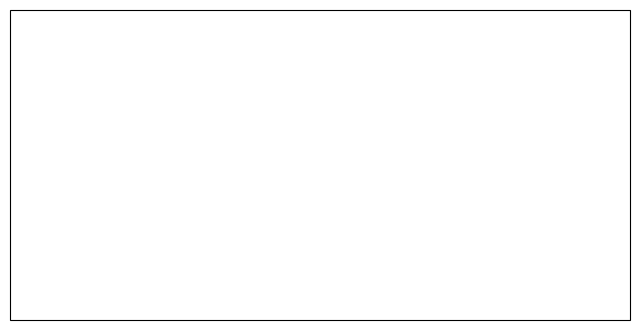

In [15]:
plot_ocn_fields(OCN_R, RMG, 'salinity')

In [11]:
def check_velocity_components(OCN_R, time_index=0, depth_index=0):
    u = OCN_R['urm'][time_index, depth_index, :, :]
    v = OCN_R['vrm'][time_index, depth_index, :, :]

    print(f"Shape of u component: {u.shape}")
    print(f"Shape of v component: {v.shape}")

    print("u component sample:")
    print(u[:5, :5])  # Print a small subset of the data for inspection

    print("v component sample:")
    print(v[:5, :5])  # Print a small subset of the data for inspection

    # Check for NaNs or masked values
    u_nan_count = np.isnan(u).sum()
    v_nan_count = np.isnan(v).sum()

    print(f"Number of NaNs in u component: {u_nan_count}")
    print(f"Number of NaNs in v component: {v_nan_count}")

    # Check if u and v are masked arrays
    if np.ma.is_masked(u):
        print("u component is a masked array")
    else:
        print("u component is not a masked array")

    if np.ma.is_masked(v):
        print("v component is a masked array")
    else:
        print("v component is not a masked array")

# Example usage:
check_velocity_components(OCN_R, time_index=0, depth_index=0)

Shape of u component: (390, 252)
Shape of v component: (389, 253)
u component sample:
[[0.016281393405047237 0.0173033789740519 0.017779610268006125
  0.01817488735712442 0.018489358858610836]
 [0.013786132691808513 0.014873389584798134 0.015469316986157788
  0.01576564377900399 0.01589089553302262]
 [0.011373268308271962 0.012411222992536657 0.013229763068842895
  0.013398682142716858 0.013407542022559477]
 [0.009113156225605996 0.010079351903218837 0.010930011538172607
  0.01119333213430138 0.011087228880957287]
 [0.006990565868463205 0.00786936826512042 0.008651675883428498
  0.009153873078959603 0.008932180933781411]]
v component sample:
[[-0.05817760811033064 -0.0619152574605762 -0.06521579999727206
  -0.06796112339706326 -0.07083151394577233]
 [-0.058803944092410035 -0.06265913403583467 -0.06667301331440874
  -0.06948283043663667 -0.07213778603122042]
 [-0.059277719030469925 -0.06334269377235116 -0.06744468891438077
  -0.07093159140976751 -0.07352708656427596]
 [-0.05995251393209